In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from datetime import datetime
import scipy.stats as stats

In [3]:
crime_data = pd.read_csv('Crime_Data_from_2020_to_present.csv')

In [4]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [7]:
times = []
for time in crime_data['TIME OCC']:
    time_str = str(time)
    if len(time_str) == 1:
        converted_time = f"00:0{time_str[-1]}:00"
    elif len(time_str) == 2:
        converted_time = f"00:{time_str[-2:]}:00"
    elif len(time_str) == 3:
        converted_time = f"0{time_str[-3]}:{time_str[-2:]}:00"
    else:
        converted_time = f"{time_str[-4:-2]}:{time_str[-2:]}:00"
    times.append(converted_time)


In [82]:
crime_data['dt'] = pd.to_datetime(pd.to_datetime(crime_data['DATE OCC']).astype(str) + ' ' + times)
#date_format = '%Y-%m-%d %H:%M:%S'
#crime_data['dt'] = [datetime.strptime(dt[i],date_format) for i in range(len(dt))]

In [83]:
crime_df = crime_data.drop(['DR_NO','Date Rptd','Crm Cd','Crm Cd 1','Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4','Part 1-2','Mocodes','Premis Cd', 
        'Premis Desc','Weapon Used Cd', 'Weapon Desc','Cross Street','Status', 'Status Desc','Rpt Dist No','DATE OCC'], axis=1,)
crime_df

,TIME OCC,AREA,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LOCATION,LAT,LON,dt
0,2230,3,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,1100 W 39TH PL,34.0141,-118.2978,2020-01-08 22:30:00
1,330,1,Central,BATTERY - SIMPLE ASSAULT,25,M,H,700 S HILL ST,34.0459,-118.2545,2020-01-01 03:30:00
2,1200,1,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,200 E 6TH ST,34.0448,-118.2474,2020-02-13 12:00:00
3,1730,15,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,5400 CORTEEN PL,34.1685,-118.4019,2020-01-01 17:30:00
4,415,19,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,14400 TITUS ST,34.2198,-118.4468,2020-01-01 04:15:00
...,...,...,...,...,...,...,...,...,...,...,...
761577,1800,16,Foothill,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",23,M,H,12500 BRANFORD ST,34.2466,-118.4054,2023-01-26 18:00:00
761578,1000,16,Foothill,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",25,F,H,12800 FILMORE ST,34.2790,-118.4116,2023-03-22 10:00:00
761579,1630,12,77th Street,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",29,M,B,6100 S VERMONT AV,33.9841,-118.2915,2023-04-12 16:30:00
761580,1,1,Central,PICKPOCKET,24,F,H,500 S MAIN ST,34.0467,-118.2485,2023-07-01 00:01:00


In [87]:
violent = ['BATTERY - SIMPLE ASSAULT','RAPE, FORCIBLE', 
           'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
           'INTIMATE PARTNER - SIMPLE ASSAULT',
           'INTIMATE PARTNER - AGGRAVATED ASSAULT','BATTERY WITH SEXUAL CONTACT',
           'BATTERY POLICE (SIMPLE)','OTHER ASSAULT',
           'SEXUAL PENETRATION W/FOREIGN OBJECT','SHOTS FIRED AT INHABITED DWELLING',
           'ORAL COPULATION','ATTEMPTED ROBBERY','ROBBERY','BRANDISH WEAPON',
           'CHILD STEALING','KIDNAPPING - GRAND ATTEMPT','KIDNAPPING',
           'SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ',
           'SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH',
           'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT','RAPE, ATTEMPTED',
           'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT','CRIMINAL HOMICIDE',
           'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER',
           'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS','BATTERY ON A FIREFIGHTER',
           'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',
           'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE','LYNCHING - ATTEMPTED',
           'MANSLAUGHTER, NEGLIGENT','WEAPONS POSSESSION/BOMBING','LYNCHING',
           'BEASTIALITY, CRIME AGAINST NATURE SEXUAL ASSLT WITH ANIM',
           'CRIMINAL THREATS - NO WEAPON DISPLAYED','THREATENING PHONE CALLS/LETTERS']
property = ['VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
            'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
            'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
            'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
            'ARSON','THEFT PLAIN - PETTY ($950 & UNDER)', 
            'THEFT OF IDENTITY','BURGLARY', 'VEHICLE - STOLEN',
            'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)','BUNCO, GRAND THEFT', 
            'THEFT, PERSON','BIKE - STOLEN','BURGLARY FROM VEHICLE',
            'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
            'THEFT FROM MOTOR VEHICLE - ATTEMPT','THROWING OBJECT AT MOVING VEHICLE',
            'EXTORTION','BURGLARY, ATTEMPTED',
            'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
            'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)','PURSE SNATCHING',
            'THEFT PLAIN - ATTEMPT','SHOPLIFTING - ATTEMPT',
            'THEFT FROM PERSON - ATTEMPT','BURGLARY FROM VEHICLE, ATTEMPTED',
            'VEHICLE - ATTEMPT STOLEN','EMBEZZLEMENT, PETTY THEFT ($950 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER',
            'CREDIT CARDS, FRAUD USE ($950 & UNDER','PICKPOCKET',
            'DOCUMENT WORTHLESS ($200 & UNDER)',
            'DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01',
            'DISHONEST EMPLOYEE - GRAND THEFT','TILL TAP - PETTY ($950 & UNDER)',
            'TILL TAP - GRAND THEFT ($950.01 & OVER)',
            'DOCUMENT WORTHLESS ($200.01 & OVER)',
            'CREDIT CARDS, FRAUD USE ($950.01 & OVER)',
            'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
            'PETTY THEFT - AUTO REPAIR','PURSE SNATCHING - ATTEMPT',
            'BIKE - ATTEMPTED STOLEN','BOAT - STOLEN',
            'THEFT, COIN MACHINE - GRAND ($950.01 & OVER)',
            'GRAND THEFT / INSURANCE FRAUD', 'DISHONEST EMPLOYEE - PETTY THEFT',
            'THEFT, COIN MACHINE - ATTEMPT',
            'THEFT, COIN MACHINE - PETTY ($950 & UNDER)','GRAND THEFT / AUTO REPAIR',
            'PICKPOCKET, ATTEMPT','TELEPHONE PROPERTY - DAMAGE',
            'DISHONEST EMPLOYEE ATTEMPTED THEFT','TRESPASSING']
other = ['SEX OFFENDER REGISTRANT OUT OF COMPLIANCE','OTHER MISCELLANEOUS CRIME',
         'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD','VIOLATION OF COURT ORDER', 
         'VIOLATION OF RESTRAINING ORDER', 'DISTURBING THE PEACE',
         'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)','BOMB SCARE',
         'DOCUMENT FORGERY / STOLEN FELONY', 'INDECENT EXPOSURE',
         'VIOLATION OF TEMPORARY RESTRAINING ORDER','RESISTING ARREST',
         'DISCHARGE FIREARMS/SHOTS FIRED', 
         'LEWD/LASCIVIOUS ACTS WITH CHILD', 'LEWD CONDUCT',
         'UNAUTHORIZED COMPUTER ACCESS','CHILD NEGLECT (SEE 300 W.I.C.)', 
         'CONTEMPT OF COURT','CHILD ANNOYING (17YRS & UNDER)', 'BUNCO, ATTEMPT',
         'PIMPING', 'STALKING','FALSE IMPRISONMENT','FAILURE TO YIELD','COUNTERFEIT',
         'PROWLER','CHILD PORNOGRAPHY','PEEPING TOM','FIREARMS RESTRAINING ORDER (FIREARMS RO)',
         'DRIVING WITHOUT OWNER CONSENT (DWOC)','CRUELTY TO ANIMALS','FALSE POLICE REPORT', 
         'PANDERING', 'ILLEGAL DUMPING','RECKLESS DRIVING','CONSPIRACY', 'CONTRIBUTING',
         'BRIBERY','DISRUPT SCHOOL','REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)',
         'DRUGS, TO A MINOR','DRUNK ROLL', 'CHILD ABANDONMENT','BIGAMY', 'FAILURE TO DISPERSE',
         'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
         'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
         'BLOCKING DOOR INDUCTION CENTER', 'INCITING A RIOT']

Timestamp('2020-01-08 22:30:00')

In [ ]:
type = []
for index, row in crime_df.iterrows():
    if row['Crm Cd Desc'] in violent:
        type.append('violent')
    elif row['Crm Cd Desc'] in property:
        type.append('property')
    else:
        type.append('other')
crime_df['type'] = type

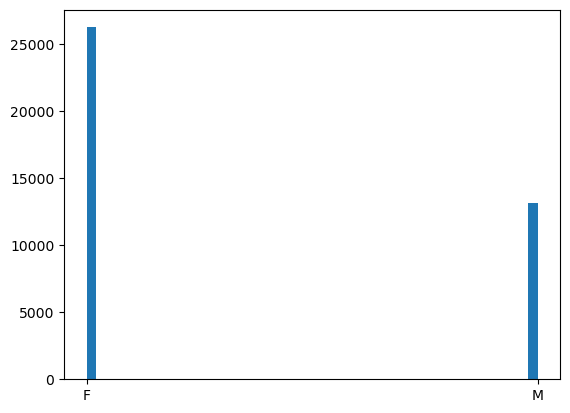

In [257]:

age_sex_df = crime_df[((crime_df['Vict Sex'] == 'M') | (crime_df['Vict Sex'] == 'F')) & (crime_df['Vict Age'] > 0)]
age_sex_df['Vict Descent'].value_counts()
age_sex_df['type'] 
#plt.hist(age_sex_df.loc[age_sex_df['type'] == 'property','Vict Age'],49)
plt.hist(age_sex_df.loc[(age_sex_df['type'] == 'other'),'Vict Sex'],49)
plt.show()
#men and women equal for violent, more men for property, significantly more women for other


In [249]:
age_sex_df.loc[age_sex_df['type'] == 'other','Crm Cd Desc'].value_counts()

VIOLATION OF RESTRAINING ORDER                              9468
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD                     6072
VIOLATION OF COURT ORDER                                    5135
OTHER MISCELLANEOUS CRIME                                   3390
CONTEMPT OF COURT                                           2210
DOCUMENT FORGERY / STOLEN FELONY                            1894
BUNCO, PETTY THEFT                                          1563
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)    1406
DISTURBING THE PEACE                                        1158
INDECENT EXPOSURE                                            931
CHILD ANNOYING (17YRS & UNDER)                               825
CHILD NEGLECT (SEE 300 W.I.C.)                               766
VIOLATION OF TEMPORARY RESTRAINING ORDER                     715
LEWD CONDUCT                                                 525
STALKING                                                     516
UNAUTHORIZED COMPUTER ACC

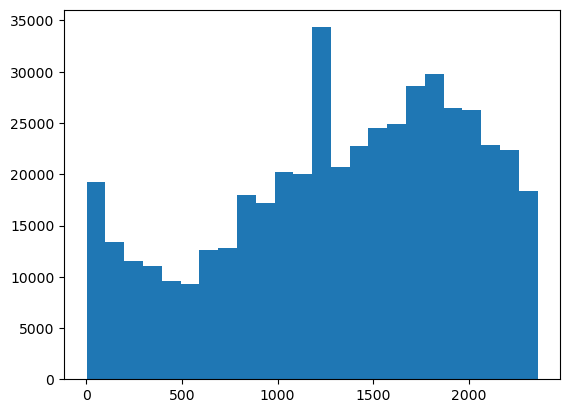

THEFT OF IDENTITY                                           4785
VEHICLE - STOLEN                                            2603
BURGLARY                                                    1866
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             1734
THEFT PLAIN - PETTY ($950 & UNDER)                          1375
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    1279
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     1079
BURGLARY FROM VEHICLE                                        927
BUNCO, GRAND THEFT                                           724
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)          672
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     488
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                   401
BIKE - STOLEN                                                323
TRESPASSING                                                  195
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     154
EXTORTION                

In [213]:
crime_type_df = crime_df[(crime_df['type'] == 'property')]# & (crime_df['TIME OCC'] != 1200)]
plt.hist(crime_type_df['TIME OCC'],24)
#plt.hist(crime_df['dt'].time())
plt.show()
#statistics.mode(crime_df['TIME OCC'])
#plt.hist(crime_df.loc[(crime_df['TIME OCC'] >= 1200) & (crime_df['TIME OCC'] < 1300),'TIME OCC'])
#peaks at 12 and 6
#time of violent crimes would likely be more well known
crime_type_df.loc[crime_type_df['TIME OCC'] == 1200,'Crm Cd Desc'].value_counts()

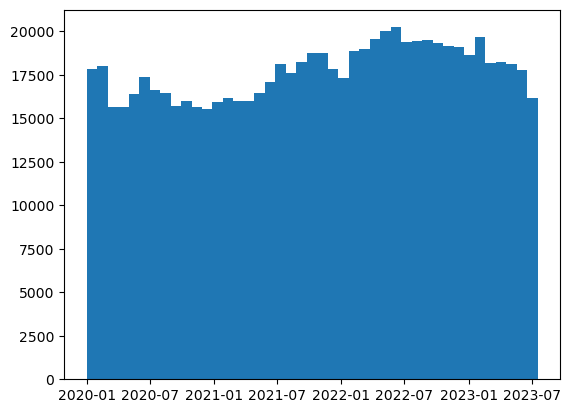

In [84]:
plt.hist(crime_df['dt'],43)
plt.show()

In [147]:
crime_df['dt'][1].weekday()
weekday = [crime_df['dt'][i].weekday() for i in range(len(crime_df))]

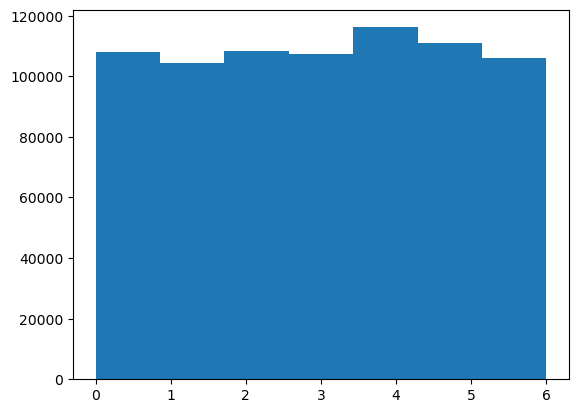

107980

In [151]:
plt.hist(weekday,7)
plt.show()

#slightly more on Friday

In [184]:
day_counts = {}
day_counts['Monday'] = weekday.count(0)
day_counts['Tuesday'] = weekday.count(1)
day_counts['Wednesday'] = weekday.count(2)
day_counts['Thursday'] = weekday.count(3)
day_counts['Friday'] = weekday.count(4)
day_counts['Saturday'] = weekday.count(5)
day_counts['Sunday'] = weekday.count(6)
day_counts.keys()
day_tester = pd.DataFrame.from_dict(day_counts,orient='index')
day_avg = len(crime_df)/7
day_tester['expected'] = day_avg
day_tester.rename(columns={0:'observed'},inplace=True)
day_tester
stats.chisquare(day_tester['observed'],day_tester['expected'])
#pd.DataFrame({'Monday':Monday,'Tuesday':Tuesday,'Wednesday':Wednesday,'Thursday':Thursday,'Friday':Friday,'Saturday':Saturday,'Sunday':Sunday})

Power_divergenceResult(statistic=822.63258322807, pvalue=1.9816994296171804e-174)

In [191]:
day_counts['Monday'] / day_avg 

0.9924866921749727

In [65]:
crime_df['Crm Cd Desc'].unique()

array(['BATTERY - SIMPLE ASSAULT',
       'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE',
       'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'RAPE, FORCIBLE', 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'OTHER MISCELLANEOUS CRIME',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'BURGLARY FROM VEHICLE', 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
       'ARSON', 'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)', 'THEFT OF IDENTITY',
       'ROBBERY', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'BURGLARY', 'VEHICLE - STOLEN',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'BRANDISH WEAPON', 'INTIMATE PARTNER - AGGRAVATED ASSAULT',
       'BUNCO, GRAND THEFT', 'THEFT, PERSON',
       'BATTERY WITH SEXUAL CONTACT', 'BIKE - STOLEN',
       'BATTERY POLICE (SIMPLE)',
       'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
       'VIOLAT

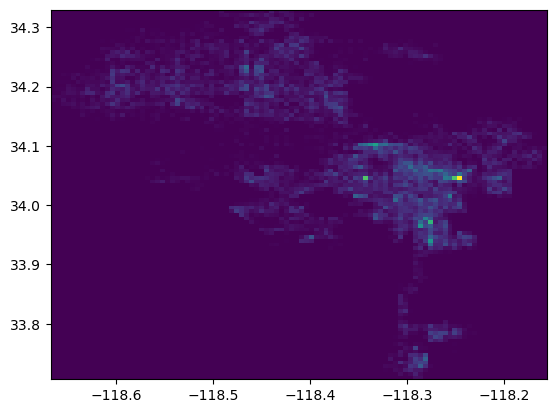

In [145]:
crime_df_loc = crime_df[(crime_df['LAT'] != 0) & (crime_df['LON'] != 0)]
crime_df_type = crime_df_loc[crime_df_loc['type'] == 'other']
plt.hist2d(crime_df_type['LON'],crime_df_type['LAT'],bins=(100,100))
#plt.xlim(-118.4,-118.2)
#plt.ylim(33.9,34.15)
plt.show()
#violent crime more concentrated

In [78]:
max(crime_df_loc['LON']) - min(crime_df_loc['LON'])
max(crime_df_loc['LAT']) - min(crime_df_loc['LAT'])

0.6281999999999996